In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage import data, io, transform
import math
from scipy import misc


In [2]:
boxes = [100,88,253,209]
img = mpimg.imread('bPawn0.jpg')
shape = img.shape

# Expands box dimensions and divides by image width/height
box = np.expand_dims(np.expand_dims(boxes,0),0)/300

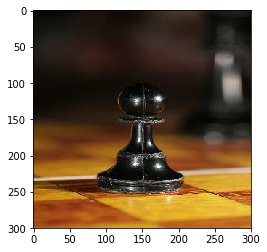

In [3]:
plt.imshow(img)
plt.show()

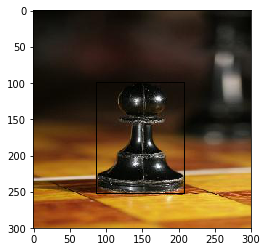

In [4]:
tf_img = tf.convert_to_tensor(np.expand_dims(img,0), np.float32)
box = tf.convert_to_tensor(box, np.float32)
test = tf.image.draw_bounding_boxes(tf_img, box)
sess = tf.Session()
image = (sess.run(test))[-1,:,:,:]/255
plt.imshow(image)

In [5]:
tf_img = tf.reshape(tf_img,[300,300,3])
begin, size, crop_box = sess.run(tf.image.sample_distorted_bounding_box(
                        image_size = tf.shape(img),
                        bounding_boxes=box,
                        min_object_covered=0.25,
                        aspect_ratio_range=[0.75, 1.33],
                        area_range=[0.5, .8],
                        max_attempts=100,
                        use_image_if_no_bounding_boxes=False))

In [6]:
boxes = tf.stack([box,crop_box], axis=2)

In [7]:
image_with_box = tf.image.draw_bounding_boxes(tf.expand_dims(tf_img, 0),
                                              boxes[-1,:,:,:])
tf.summary.image ('images_with_box', image_with_box)

<tf.Tensor 'images_with_box:0' shape=() dtype=string>

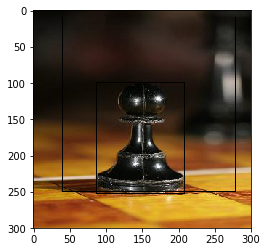

In [8]:
image = sess.run(image_with_box)
plt.imshow(image[-1,:,:,:]/255)
plt.show()

In [9]:
# Wil take newly cropped box from original image and rescale the object box to the newly cropped image.

old_box = sess.run(box)
new_box = np.zeros([1,1,4])

if crop_box[:,:,0] > old_box[:,:,0]:
    new_box[:,:,0] = 0
else:
    new_box[:,:,0] = (old_box[:,:,0] - crop_box[:,:,0]) / (crop_box[:,:,2] - crop_box[:,:,0])

if crop_box[:,:,2] < old_box[:,:,2]:
    new_box[:,:,2] = 1
else:
    new_box[:,:,2] = (old_box[:,:,2] - crop_box[:,:,0]) / (crop_box[:,:,2] - crop_box[:,:,0])
    
if crop_box[:,:,1] > old_box[:,:,1]:
    new_box[:,:,1] = 0
else:
    new_box[:,:,1] = (old_box[:,:,1] - crop_box[:,:,1]) / (crop_box[:,:,3] - crop_box[:,:,1])

if crop_box[:,:,3] < old_box[:,:,3]:
    new_box[:,:,3] = 1
else:
    new_box[:,:,3] = (old_box[:,:,3] - crop_box[:,:,1]) / (crop_box[:,:,3] - crop_box[:,:,1])

In [10]:
distorted_image = sess.run(tf.slice(tf_img, begin, size))
tf_img = np.expand_dims(distorted_image, axis=0)
distorted_with_box = tf.image.draw_bounding_boxes(tf_img,new_box)
image = (sess.run(distorted_with_box))

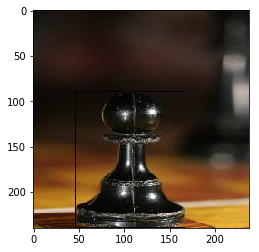

In [11]:
# Randomly Cropped Image w/ New Bounding Box
plt.imshow(image[-1,:,:,:]/255)

/home/justin/envs/ml/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


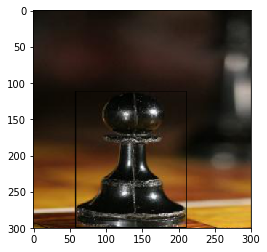

In [12]:
# Darknet / Yolo will resize the bounding box as long as it's in yolo format,
# Cropping and resizing the object adds even more scale image augmentation. A+
resized = transform.resize(image[-1,:,:,:]/255,[300,300,3])
plt.imshow(resized)

In [13]:
# SCRIPT FOR CROPPING OBJECT w/ PADDING, ROTATING AND PLACING BACK INTO ORIGINAL

In [14]:
# Takes in text file of darkNet coords and
# converts [center x, center y, width height]
# to [y_min, x_min, y_max, x_max]

def convert_bb(labels):
    
#   Read text file
    labels = open(labels, 'r')
    
    old_boxes = []
    while True:
        line = labels.readline()
        line = line.strip()
        line = line.split()
#       Convert classes to ints and values to floats
        for i in range(len(line)):
            if len(line[i]) > 1:
                line[i] = float(line[i])
            else:
                line[i] = int(line[i])
        if line == []:
            break
        old_boxes.append(line)
    
#   [batch, number of bounding boxes, coords]
    num_boxes = len(old_boxes)
    boxes = np.zeros([1,num_boxes,4])
    classes = np.zeros([num_boxes])
    
    for i in range(num_boxes):
        boxes[:,i,0] = (old_boxes[i][2]-old_boxes[i][4]/2)
        boxes[:,i,1] = (old_boxes[i][1]-old_boxes[i][3]/2)
        boxes[:,i,2] = (old_boxes[i][2]+old_boxes[i][4]/2)
        boxes[:,i,3] = (old_boxes[i][1]+old_boxes[i][3]/2)
        classes[i] = old_boxes[i][0]
    
    return num_boxes, boxes, old_boxes, classes.astype(int)

In [15]:
num, boxes, old_boxes, classes = convert_bb('labels.txt')

(704, 1280, 3)


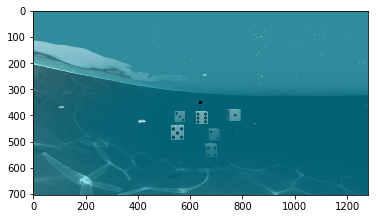

In [16]:
# ORIGINAL IMAGE
img = mpimg.imread('dice.jpg')
shape = img.shape
plt.imshow(img)
rot = 10
ycenter = int((img.shape[0]/2))
xcenter = int((img.shape[1]/2))
img.setflags(write=1)
img[ycenter-5:ycenter+5,xcenter-5:xcenter+5,:] = 0
plt.imshow(img)
print(img.shape)

In [21]:
rotated = transform.rotate(img,rot,mode='constant')

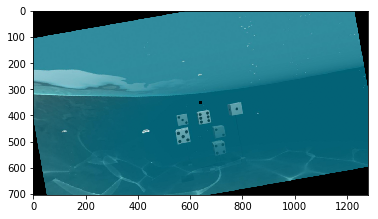

In [22]:
plt.imshow(rotated)

In [24]:
boxes

array([[[0.61931821, 0.41171875, 0.70170458, 0.45078125],
        [0.54687496, 0.48281255, 0.61647724, 0.52187505],
        [0.53551138, 0.57734375, 0.59943182, 0.61953125],
        [0.71875   , 0.5125    , 0.796875  , 0.55      ],
        [0.54545455, 0.4226562 , 0.60511364, 0.4539062 ],
        [0.63920455, 0.52109375, 0.70454545, 0.55703125]]])

In [25]:
# CONVERT BOUNDING BOXES [ymin,xmin,ymax,xmas]
# WRT TO CENTER RANGE [-0.5,0.5]
boxes2 = boxes-0.5
# INVERT Y AXIS
boxes2[:,:,0] = -boxes2[:,:,0]
boxes2[:,:,2] = -boxes2[:,:,2]
print(boxes2)

[[[-0.11931821 -0.08828125 -0.20170458 -0.04921875]
  [-0.04687496 -0.01718745 -0.11647724  0.02187505]
  [-0.03551138  0.07734375 -0.09943182  0.11953125]
  [-0.21875     0.0125     -0.296875    0.05      ]
  [-0.04545455 -0.0773438  -0.10511364 -0.0460938 ]
  [-0.13920455  0.02109375 -0.20454545  0.05703125]]]


In [26]:
rot = 10
rads = np.deg2rad(rot)
rotation_matrix = np.array([[np.cos(rads), -np.sin(rads)],
                            [np.sin(rads), np.cos(rads)]])

In [27]:
def rotate_points(coords):
    min_xy = np.matmul(rotation_matrix,np.array([[coords[1]],
                                                [coords[0]]]))
    max_xy = np.matmul(rotation_matrix,np.array([[coords[3]],
                                                [coords[2]]]))
    min_xy = min_xy.reshape(2)
    max_xy = max_xy.reshape(2)
    
    min_xy[0] = min_xy[0]+0.5
    min_xy[1] = (-min_xy[1])+0.5
    max_xy[0] = max_xy[0]+0.5
    max_xy[1] = (-max_xy[1])+0.5
    
    return [min_xy[1],min_xy[0],max_xy[1],max_xy[0]]

In [28]:
new_box = rotate_points(boxes2[-1,1,:])

In [29]:
new_box

[0.5491473983254174,
 0.49121341823594145,
 0.610909121508552,
 0.5417687784349625]

In [30]:
new_box = np.expand_dims(np.expand_dims(new_box,0),0)

In [31]:
new_box

array([[[0.5491474 , 0.49121342, 0.61090912, 0.54176878]]])

In [32]:
tf_img = tf.convert_to_tensor(np.expand_dims(rotated,0), np.float32)
tf_box = tf.convert_to_tensor(new_box, np.float32)

In [33]:
image_with_box = tf.image.draw_bounding_boxes(tf_img,tf_box)

In [34]:
image = sess.run(image_with_box)

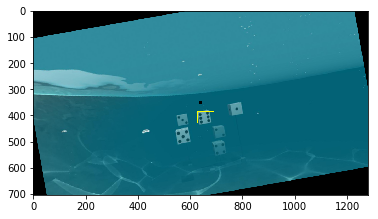

In [35]:
plt.imshow(image[-1,:,:,:])

In [37]:
misc.imshow(image[-1,:,:,:])

/home/justin/envs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imshow` is deprecated!
`imshow` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``matplotlib.pyplot.imshow`` instead.
  """Entry point for launching an IPython kernel.
